In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sbpy.photometry import HG1G2, HG
import pyarrow.parquet as pq
import pandas as pd
from astropy.modeling import models, fitting
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
import os
import time
import warnings
warnings.filterwarnings("ignore")


# Defining functions

In [2]:
def hg_phase_function(alpha, H, G):
    # Phase functions Phi1 and Phi2
    W = np.exp(-3.33 * np.tan(alpha/2)**0.63)
    R = np.exp(-1.87 * np.tan(alpha/2)**1.22)
    return H - 2.5 * np.log10((1 - G) * W + G * R)

    # Standard G part
    func1 = (1.0 - G) * HG._hgphi(alpha, 1) + G * HG._hgphi(alpha, 2)
    # func1 = -2.5 * np.log10(func1)

    # return H + func1

# Define the H, G1, G2 phase function
def hg1g2_phase_function(alpha, H, G1, G2):
    tan_half_alpha = np.tan(alpha / 2)
    phi1 = np.exp(-3.332 * tan_half_alpha ** 0.631)
    phi2 = np.exp(-1.862 * tan_half_alpha ** 1.218)
    phi3 = np.exp(-1.218 * tan_half_alpha ** 2.591)
    return H - 2.5 * np.log10(G1 * phi1 + G2 * phi2 + (1.0 - G1 - G2) * phi3)

    # func1 = G1 * HG1G2._phi1(alpha) + G2 * HG1G2._phi2(alpha) +\
    #     (1.0 - G1 - G2) * HG1G2._phi3(alpha)
    # func1 = -2.5 * np.log10(func1)
    # return H + func1

def hg_fit(x, y, initial_guess):
    # Fit the H, G phase function to the observed data
    best_fit, covariance = curve_fit(hg_phase_function, 
            x, y, p0=initial_guess, maxfev=5000)
    # H_fit, G_fit = best_fit

    # Calculate standard deviations (sqrt of the diagonal of the covariance matrix)
    # H_std, G_std = np.sqrt(np.diag(covariance))

    # print(f"Best fit H: {H_fit:.4f} +/- {H_std:.4f}")
    # print(f"Best fit G: {G_fit:.4f} +/- {G_std:.4f}")

    return best_fit, np.sqrt(np.diag(covariance))

def hg1g2_fit(x, y, initial_guess):
    # Fit the H, G1, G2 phase function to the observed data
    best_fit, covariance = curve_fit(hg1g2_phase_function, 
            x, y, p0=initial_guess, maxfev=5000)
    # H_fit, G1_fit, G2_fit = best_fit

    # Calculate standard deviations (sqrt of the diagonal of the covariance matrix)
    # H_std, G1_std, G2_std = np.sqrt(np.diag(covariance))
    # print(f"Best fit H: {H_fit:.4f} +/- {H_std:.4f}")
    # print(f"Best fit G1: {G1_fit:.4f} +/- {G1_std:.4f}")
    # print(f"Best fit G2: {G2_fit:.4f} +/- {G2_std:.4f}")

    return best_fit, np.sqrt(np.diag(covariance))


# Ploting

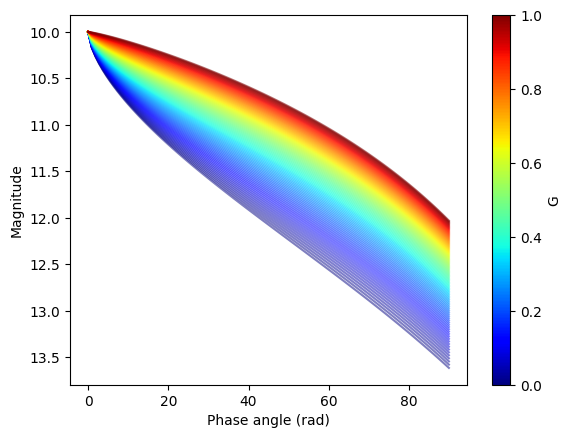

In [3]:
phases = np.linspace(0, np.pi/2, 100)
H = 10
fig = plt.figure()
for G in np.linspace(0.0, 1.0, 100):
    plt.plot(phases * 180.0 / np.pi, 
             hg_phase_function(phases, H, G), 
             color=plt.cm.jet(G),
             alpha=0.5,
            #  label=f'G={G:.1f}'
             )

# invert axis
plt.gca().invert_yaxis()
sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('jet'))
sm.set_clim(vmin=0, vmax=1)
plt.colorbar(sm, label='G')

plt.xlabel('Phase angle (rad)')
plt.ylabel('Magnitude')
# plt.legend()
plt.show()

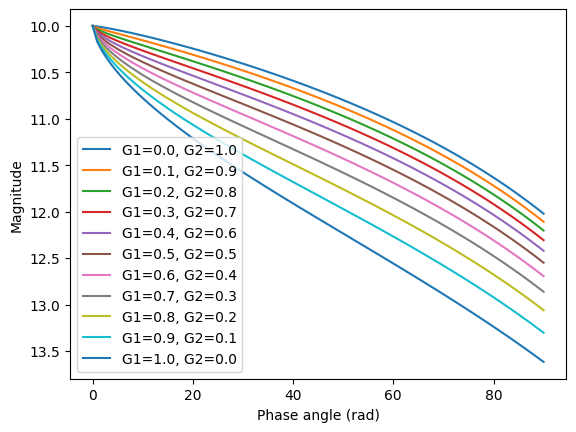

In [4]:
phases = np.linspace(0, np.pi/2, 100)
H = 10
fig = plt.figure()
for G1 in np.linspace(0.0, 1.0, 11):
    G2 = 1.0 - G1
    plt.plot(phases * 180.0 / np.pi, 
             hg1g2_phase_function(phases, H, G1, G2), label=f'G1={G1:.1f}, G2={G2:.1f}')
    
# invert axis
plt.gca().invert_yaxis()
plt.xlabel('Phase angle (rad)')
plt.ylabel('Magnitude')
plt.legend()
plt.show()

In [5]:
n = 10_000
phases = np.linspace(0, np.pi/2, 100)
H = 10

g1 = np.random.normal(0.4, 0.28, n)
g2 = np.random.normal(0.25, 0.11, n)
cond = (g1 + g2 <= 1) & (g1 + g2 >= 0) &  (g1 >= 0) & (g2 >= 0.0)


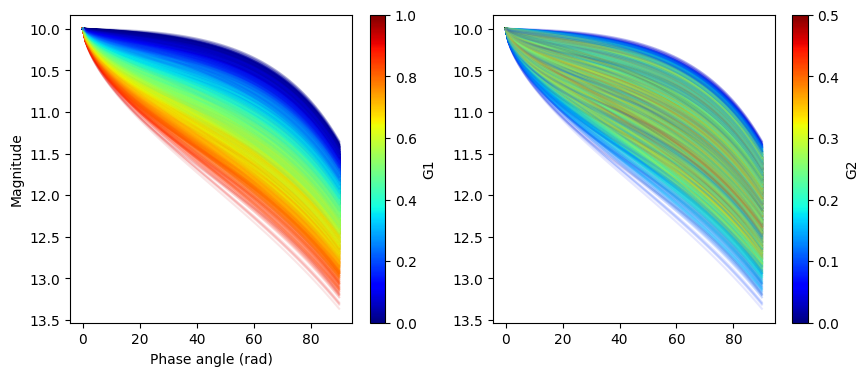

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
# del range
for i in range(n):
    G1 = g1[i]
    G2 = g2[i]
    if (G1 + G2 <= 1) & (G1 + G2 >= 0) &  (G1 >= 0) & (G2 >= 0.0):
        # continue
        ax[0].plot(phases * 180.0 / np.pi,
                hg1g2_phase_function(phases, H, G1, G2), 
                color=plt.cm.jet(G1), alpha=0.1)
        ax[1].plot(phases * 180.0 / np.pi,
                hg1g2_phase_function(phases, H, G1, G2), 
                color=plt.cm.jet(G2*2), alpha=0.1)
# invert axis
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_xlabel('Phase angle (rad)')
ax[0].set_ylabel('Magnitude')

sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('jet'))
sm.set_clim(vmin=0, vmax=1.0)
plt.colorbar(sm, label='G1', ax=ax[0])

sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('jet'))
sm.set_clim(vmin=0, vmax=0.5)
plt.colorbar(sm, label='G2', ax=ax[1])
plt.savefig('./figs/hg1g2_models.png')
plt.show()


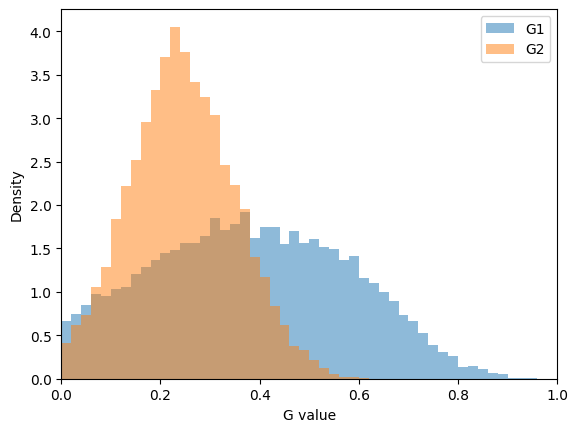

In [8]:
hbins = 50
hrange = (0, 1)
cond = (g1 + g2 <= 1) & (g1 + g2 >= 0) &  (g1 >= 0) & (g2 >= 0.0)
plt.hist(g1[cond], bins=hbins, range=hrange, alpha=0.5, label='G1', density=True)
plt.hist(g2[cond], bins=hbins, range=hrange, alpha=0.5, label='G2', density=True)
plt.legend()
plt.xlim(0, 1)
plt.xlabel('G value')
plt.ylabel('Density')
plt.show()

# BFT

## Load data

In [7]:
# Replace 'path_to_your_parquet_file.parquet' with the actual file path
file_path = './data/ssoBFT-latest.parquet'


In [ ]:

# Open the Parquet file
parquet_file = pq.ParquetFile(file_path)

# Read the first 10 rows
first_10_rows = parquet_file.read_row_group(0, columns=None).to_pandas().head(1)

first_10_rows


In [66]:
[x for x in first_10_rows.columns if 'phase_functions' in x.lower()]

['phase_functions.Generic/Johnson.V.H.value',
 'phase_functions.Generic/Johnson.V.H.error.min',
 'phase_functions.Generic/Johnson.V.H.error.max',
 'phase_functions.Generic/Johnson.V.G1.value',
 'phase_functions.Generic/Johnson.V.G1.error.min',
 'phase_functions.Generic/Johnson.V.G1.error.max',
 'phase_functions.Generic/Johnson.V.G2.value',
 'phase_functions.Generic/Johnson.V.G2.error.min',
 'phase_functions.Generic/Johnson.V.G2.error.max',
 'phase_functions.Generic/Johnson.V.N',
 'phase_functions.Generic/Johnson.V.phase.min',
 'phase_functions.Generic/Johnson.V.phase.max',
 'phase_functions.Generic/Johnson.V.rms',
 'phase_functions.Generic/Johnson.V.facility',
 'phase_functions.Generic/Johnson.V.technique',
 'phase_functions.Generic/Johnson.V.name_filter',
 'phase_functions.Misc/Atlas.orange.H.value',
 'phase_functions.Misc/Atlas.orange.H.error.min',
 'phase_functions.Misc/Atlas.orange.H.error.max',
 'phase_functions.Misc/Atlas.orange.G1.value',
 'phase_functions.Misc/Atlas.orange.G1.e

In [8]:
cols = ['sso_number',
    'phase_functions.Generic/Johnson.V.H.value',
    # 'phase_functions.Generic/Johnson.V.G.value',
        'phase_functions.Generic/Johnson.V.G1.value',
        'phase_functions.Generic/Johnson.V.G2.value',]
df = pd.read_parquet(file_path, engine='pyarrow', columns=cols)
df.dropna(inplace=True)
df

sso_number  phase_functions.Generic/Johnson.V.H.value  \
0           31631.0                                  14.319896   
1           31466.0                                  14.483206   
2           31613.0                                  14.334018   
3           31569.0                                  14.045721   
6           31192.0                                  13.759974   
...             ...                                        ...   
1202820    202002.0                                  17.252728   
1202821    202008.0                                  16.828906   
1202824    202018.0                                  17.005135   
1202827    202029.0                                  17.478378   
1202829    202022.0                                  16.318238   

         phase_functions.Generic/Johnson.V.G1.value  \
0                                          0.460137   
1                                          0.338533   
2                                          0.608200   
3                                          0.332235   
6                                          0.574207   
...                                             ...   
1202820                                    0.025342   
1202821                                    0.434771   
1202824                                    0.110359   
1202827                                    0.375457   
1202829                                    0.278774   

         phase_functions.Generic/Johnson.V.G2.value  
0                                          0.407384  
1                                          0.242414  
2                                          0.133466  
3                                          0.297542  
6                                          0.151169  
...                                             ...  
1202820                                    0.795425  
1202821                                    0.168766  
1202824                                    0.381974  
1202827                                    0.292100  
1202829                                    0.332385  

[146636 rows x 4 columns]

In [26]:
df.sso_number.max()

621762.0

## Plot phase models

/tmp/ipykernel_1487261/1124144473.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('jet'))
/tmp/ipykernel_1487261/1124144473.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('jet'))


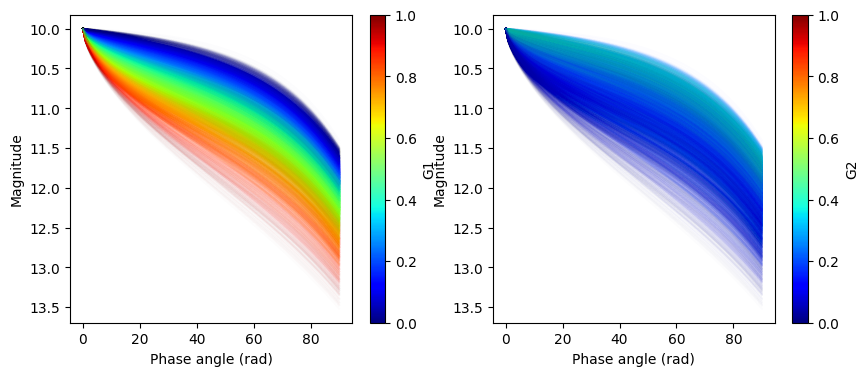

In [12]:
phases = np.linspace(0, np.pi/2, 100)
H = 10
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, (idx, row) in enumerate(df[:10_000].iterrows()):
    G1 = row['phase_functions.Generic/Johnson.V.G1.value']
    G2 = row['phase_functions.Generic/Johnson.V.G2.value']
    if (G1 + G2 <= 1) & (G1 + G2 >= 0) &  (G1 >= 0) & (G2 >= 0.0):
        # continue
        ax[0].plot(phases * 180.0 / np.pi,
                hg1g2_phase_function(phases, H, G1, G2), 
                color=plt.cm.jet(G1), alpha=0.01)
        ax[1].plot(phases * 180.0 / np.pi,
                hg1g2_phase_function(phases, H, G1, G2), 
                color=plt.cm.jet(G2), alpha=0.01)
# invert axis
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_xlabel('Phase angle (rad)')
ax[0].set_ylabel('Magnitude')
ax[1].set_xlabel('Phase angle (rad)')
ax[1].set_ylabel('Magnitude')

sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('jet'))
sm.set_clim(vmin=0, vmax=1.0)
plt.colorbar(sm, label='G1', ax=ax[0])

sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('jet'))
sm.set_clim(vmin=0, vmax=1.0)
plt.colorbar(sm, label='G2', ax=ax[1])

plt.show()


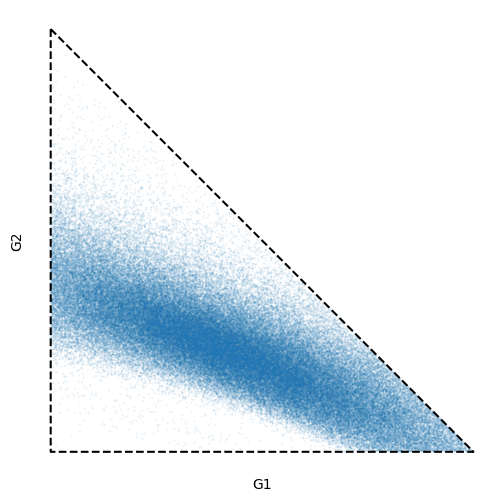

In [19]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
plt.scatter(df['phase_functions.Generic/Johnson.V.G1.value'],
            df['phase_functions.Generic/Johnson.V.G2.value'],
            alpha=0.1, s=2, edgecolors='none')
plt.plot([0, 1, 0, 0], [1, 0, 0, 1], color='k', linestyle='--')
plt.axis('equal')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xlabel('G1')
plt.ylabel('G2')
plt.savefig('./figs/g1g2_bft_distribution.png')
plt.show()

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev      
    ------------------ ------------------ -------------------
    1.5385470545136106 0.3963050892196637 0.29232807852898207
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean               stddev      
    ----------------- ------------------- -------------------
    3.359080987290244 0.24180431139659928 0.12031994651681399


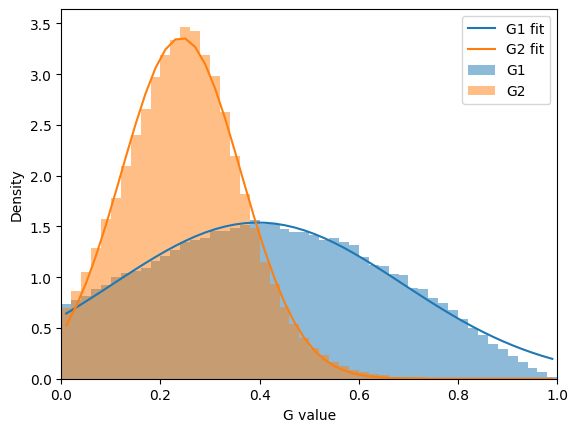

In [14]:
hbins = 50
hrange = (0.0, 1.0)
hist_g1, bins_g1 = np.histogram(df['phase_functions.Generic/Johnson.V.G1.value'], bins=hbins, range=hrange, density=True)
hist_g2, bins_g2 = np.histogram(df['phase_functions.Generic/Johnson.V.G2.value'], bins=hbins, range=hrange, density=True)
w = (bins_g1[1] - bins_g1[0])
center = (bins_g1[:-1] + bins_g1[1:]) / 2

fit_method = fitting.LevMarLSQFitter()
g1_init = models.Gaussian1D(amplitude=1., mean=0.4, stddev=0.28)
g1_fit = fit_method(g1_init, center, hist_g1)
g2_init = models.Gaussian1D(amplitude=1., mean=0.25, stddev=0.11)
g2_fit = fit_method(g2_init, center, hist_g2)
print(g1_fit)
print(g2_fit)

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
plt.bar(center, hist_g1, align='center', width=w, alpha=0.5, label='G1')
plt.bar(center, hist_g2, align='center', width=w, alpha=0.5, label='G2')
plt.plot(center, g1_fit(center), label='G1 fit')
plt.plot(center, g2_fit(center), label='G2 fit')
plt.legend()
plt.xlim(0, 1)
plt.xlabel('G value')
plt.ylabel('Density')
plt.show()

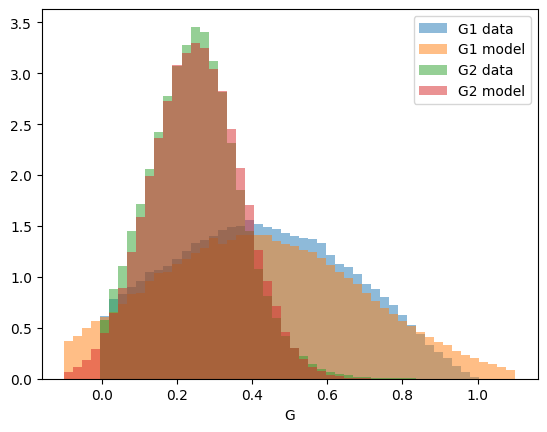

In [18]:
hbins = 50
hrange = (-0.1, 1.1)
n = 100_000
g1 = np.random.normal(0.4, 0.3, n)
g2 = np.random.normal(0.25, 0.12, n)
plt.figure()
plt.hist(df['phase_functions.Generic/Johnson.V.G1.value'],
          bins=hbins, alpha=0.5, density=True, range=hrange,
          label='G1 data')
plt.hist(g1, bins=hbins, alpha=0.5, density=True, range=hrange,
            label='G1 model')
plt.hist(df['phase_functions.Generic/Johnson.V.G2.value'], range=hrange, 
         bins=hbins, alpha=0.5, density=True, label='G2 data')
plt.hist(g2, bins=hbins, alpha=0.5, density=True,  range=hrange, 
         label='G2 model')

plt.legend()
# plt.xlim(0, 1)
plt.xlabel('G')
plt.show()

In [28]:
hist_h, bins_h = np.histogram(df['phase_functions.Generic/Johnson.V.H.value'], 
                              bins=50, density=True, range=(10, 20))
w = (bins_h[1] - bins_h[0])
center = (bins_h[:-1] + bins_h[1:]) / 2

fit_method = fitting.LevMarLSQFitter()
h_init = models.Gaussian1D(amplitude=0.3, mean=16, stddev=0.5)
h_fit = fit_method(h_init, center, hist_h)
print(h_fit)

plt.figure()
plt.bar(center, hist_h, align='center', width=w, alpha=0.5, label='H')
plt.plot(center, h_fit(center), label='H fit')
plt.xlabel('Absolute magnitude')
plt.ylabel('Density')
plt.legend()
plt.show()

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude             mean              stddev      
    ------------------- ------------------ ------------------
    0.32542926158784935 15.322729045803149 1.2116863325450373


# Statistics parameters of MPC observations

## Example of MPC observation

In [28]:
path = './data/phase/010000/'
scan = os.scandir(path)
file_list = [entry.path for entry in scan if entry.is_file()]
file_list.sort()
print(len(file_list), 'files found')

1103 files found


In [29]:
df_correction = pd.read_csv('./data/bands_correction.csv')
df_correction.set_index(['observatory', 'band'], inplace=True)
df_correction[:5]

mean       std    n_obs
observatory band                             
704         0     0.135415  0.399920  3366566
F51         w    -0.156022  0.155117  3268551
G96         G    -0.152969  0.218798  2585921
T08         o    -0.341309  0.194491  2546054
G96         V    -0.266422  0.278966  2055628

In [30]:
def chr2numb(x):
    val = str(x)[0]
    if val.isalpha():
        if (val > 'A') & (val <= 'Z'):
            return int(ord(val) - 55)*10000 + int(x[1:])
        else:
            return int(ord(val) - 61)*10000 + int(x[1:])
    else:
        return int(x)

Best fit H: 15.2947 +/- 0.0335
Best fit G: 0.1586 +/- 0.0303
Observed dispersion: 0.2752
Best fit H: 15.3070 +/- 0.0350
Best fit G1: 0.7893 +/- 0.0548
Best fit G2: 0.2906 +/- 0.1182
Observed dispersion: 0.1263


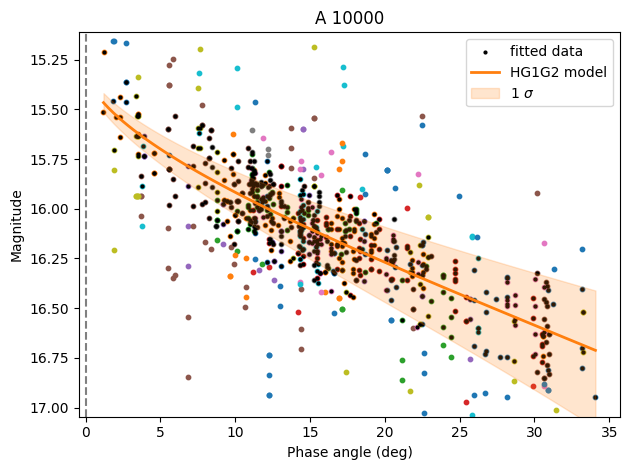

Best fit H: 14.1081 +/- 0.0287
Best fit G: 0.1829 +/- 0.0260
Observed dispersion: 0.4494
Best fit H: 14.0253 +/- 0.0383
Best fit G1: 0.7363 +/- 0.0733
Best fit G2: 0.2707 +/- 0.1672
Observed dispersion: 0.2527


Best fit H: 13.6206 +/- 0.0196
Best fit G: 0.1210 +/- 0.0209
Observed dispersion: 0.3538
Best fit H: 13.5791 +/- 0.0218
Best fit G1: 0.8281 +/- 0.0523
Best fit G2: 0.1952 +/- 0.1496
Observed dispersion: 0.1903


Best fit H: 14.7460 +/- 0.0201
Best fit G: 0.1466 +/- 0.0175
Observed dispersion: 0.4044
Best fit H: 14.6377 +/- 0.0215
Best fit G1: 0.9176 +/- 0.0398
Best fit G2: -0.0684 +/- 0.0931
Observed dispersion: 0.2341


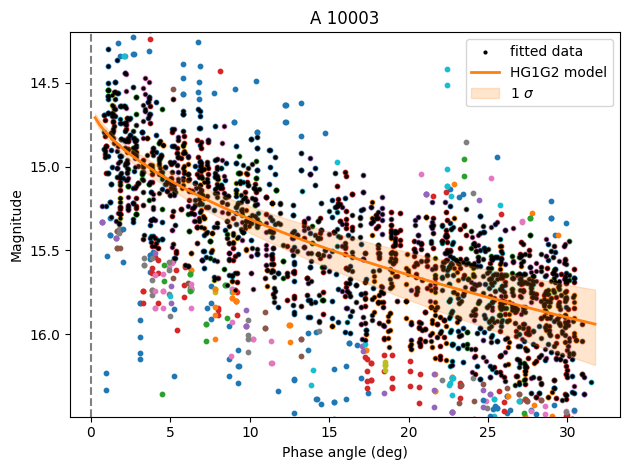

Best fit H: 13.0547 +/- 0.0184
Best fit G: 0.0566 +/- 0.0188
Observed dispersion: 0.3066
Best fit H: 12.8994 +/- 0.0171
Best fit G1: 1.1449 +/- 0.0324
Best fit G2: -0.5755 +/- 0.0943
Observed dispersion: 0.1430


In [37]:
bad_list = [('K95', 'R'), ('608', '0'), ('Z22', 'w'), ('C51', 'R'), ('D29', 'R'),
            ('703', 'V'), ('703', 'G'), ('Z22', 'R'), ('644', '0'), ('W92', 'R'),
            ('N86', 'G'), ('J04', 'R'), ('703', 'R'), ('C41', 'w')]
bad_list = [('C57', 'G')]

a = 0
for i, file in enumerate(file_list[a:a+5]):
    # df = pd.read_csv(file, usecols=['mag', 'Phase', 'epoch', 'observatory', 'band', 'Dhelio', 'Dobs', 'VMag'])
    df = pd.read_csv(file)
    df = df[df['band'].isnull() == False]
    df['numb'] = df['number'].apply(chr2numb)
    min_phase = df['Phase'].min() / 180.0 * np.pi
    max_phase = df['Phase'].max() / 180.0 * np.pi
    df_uniques = df.value_counts(subset=['observatory', 'band'])
    df_uniques= df_uniques[df_uniques > 10]
    df_current_correction = pd.merge(df_correction, df_uniques, how='inner', left_index=True, right_index=True)

    plt.figure()
    # obs_list = cond[cond].index
    x_obs, y_obs = [], []
    for idx, row in df_current_correction.iterrows():
        # print(idx, row['mean'])
        if idx in bad_list:
            continue
        cond = (df['observatory'] == idx[0]) & (df['band'] == idx[1])
        x = df.loc[cond, 'Phase'] / 180.0 * np.pi
        y = df.loc[cond, 'mag'] -  5 * np.log10(df.loc[cond, 'Dhelio'] * df.loc[cond, 'Dobs']) - row['mean']
        x_obs.extend(x.values)
        y_obs.extend(y.values)
        plt.scatter(x * 180.0 / np.pi, y, s=10, alpha=1.0, 
                    # label=f'{idx}'
                    )

    # Sort the observed data by phase angle
    x_obs = np.array(x_obs)
    sort_idx = np.argsort(x_obs)
    x_obs = x_obs[sort_idx]
    y_obs = np.array(y_obs)[sort_idx]

    # Fit the H, G phase function to the observed data
    initial_guess = [np.median(y_obs), 0.4]
    (H1_fit, G_fit), (H1_std, G_std) = hg_fit(x_obs, y_obs, initial_guess)
    residual = y_obs - hg_phase_function(x_obs, H1_fit, G_fit)
    obs_dispersion = np.std(residual)
    print(f"Best fit H: {H1_fit:.4f} +/- {H1_std:.4f}")
    print(f"Best fit G: {G_fit:.4f} +/- {G_std:.4f}")
    print(f'Observed dispersion: {obs_dispersion:.4f}')
    
    # sigma clipping
    filtered_data = sigma_clip(residual, sigma=2, maxiters=5)
    x_obs = x_obs[~filtered_data.mask]
    y_obs = y_obs[~filtered_data.mask]
    
    # Fit the H, G1, G2 phase function to the observed data
    initial_guess = [np.median(y_obs), 0.4, 0.25]
    (H2_fit, G1_fit, G2_fit), (H2_std, G1_std, G2_std) = hg1g2_fit(x_obs, y_obs, initial_guess)
    obs_dispersion = np.std(y_obs-hg1g2_phase_function(x_obs, H2_fit, G1_fit, G2_fit))
    print(f"Best fit H: {H2_fit:.4f} +/- {H2_std:.4f}")
    print(f"Best fit G1: {G1_fit:.4f} +/- {G1_std:.4f}")
    print(f"Best fit G2: {G2_fit:.4f} +/- {G2_std:.4f}")
    print(f'Observed dispersion: {obs_dispersion:.4f}')

    # Plot the observed data
    plt.scatter(x_obs * 180.0 / np.pi, y_obs, s=4, alpha=1.0, color='black',
                label='fitted data')

    xx = np.linspace(min_phase, max_phase, 100)
    # plt.plot(xx * 180.0 / np.pi, hg_phase_function(xx, H1_fit, G_fit),
    #                 label='HG model')
    plt.plot(xx * 180.0 / np.pi, hg1g2_phase_function(xx, H2_fit, G1_fit, G2_fit),
                    label='HG1G2 model', color=plt.cm.tab10(1), lw=2)
    plt.fill_between(xx * 180.0 / np.pi,
                    hg1g2_phase_function(xx, H2_fit - H2_std, G1_fit - G1_std, G2_fit - G2_std),
                    hg1g2_phase_function(xx, H2_fit + H2_std, G1_fit + G1_std, G2_fit + G2_std),
                    alpha=0.2, label=r'1 $\sigma$', color=plt.cm.tab10(1))
    plt.axvline(x=0, color='gray', linestyle='--')

    plt.gca().invert_yaxis()
    plt.xlabel('Phase angle (deg)')
    plt.ylabel('Magnitude')
    # plt.xlim(right=45)
    plt.ylim(y_obs.max()+0.1, y_obs.min()-0.1)
    plt.title(f'A {df.iloc[0]["numb"]}')
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./figs/hg1g2data/fit_{df.iloc[0]["numb"]}.png')
    plt.show()


# The Mock phase curves

In [25]:
g1 = g1_fit.mean.value
g2 = g2_fit.mean.value
H = 15.0
xx = np.linspace(0, np.pi/2, 100)
plt.figure()
plt.plot(xx * 180.0 / np.pi, hg1g2_phase_function(xx, H, g1, g2), 
         label=f'model H={H:.1f}, G1={g1:.1f}, G2={g2:.1f}')
plt.xlabel('Phase angle, deg')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()


NameError: name 'g1_fit' is not defined

Best fit H: 16.0081 +/- 0.0171
Best fit G1: 0.4226 +/- 0.0417
Best fit G2: 0.1708 +/- 0.0902


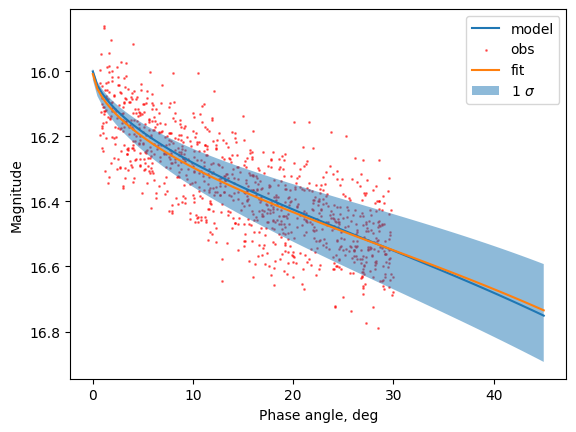

In [26]:
n_obs = 1000 # number of observations
sigma = 0.1 # mag
H = 16
g1 = 0.4
g2 = 0.25
xx = np.linspace(0, np.pi/4, 100)
np.random.seed(42)
x0 = np.random.uniform(0.01, 30 * np.pi / 180, n_obs)
y0 = hg1g2_phase_function(x0, H, g1, g2)
y_obs = y0 + np.random.normal(0, sigma, n_obs)

# Initial guess for H, G1, and G2
initial_guess = [H, g1, g2]
# Fit the H, G1, G2 phase function to the observed data
best_fit1, covariance1 = curve_fit(hg1g2_phase_function, 
        x0, y_obs, p0=initial_guess, maxfev=5000)
H1_fit, G1_fit, G2_fit = best_fit1

# Calculate standard deviations (sqrt of the diagonal of the covariance matrix)
H1_std, G1_std, G2_std = np.sqrt(np.diag(covariance1))
print(f"Best fit H: {H1_fit:.4f} +/- {H1_std:.4f}")
print(f"Best fit G1: {G1_fit:.4f} +/- {G1_std:.4f}")
print(f"Best fit G2: {G2_fit:.4f} +/- {G2_std:.4f}")

plt.figure()
plt.plot(xx * 180.0 / np.pi, hg1g2_phase_function(xx, H, g1, g2), label='model')
plt.scatter(x0 * 180.0 / np.pi, y_obs, label='obs', s=1,
            color='red', alpha=0.5)
plt.plot(xx * 180.0 / np.pi, hg1g2_phase_function(xx, H1_fit, G1_fit, G2_fit),
                label='fit')
plt.fill_between(xx * 180.0 / np.pi,
                hg1g2_phase_function(xx, H1_fit - H1_std, G1_fit - G1_std, G2_fit - G2_std),
                hg1g2_phase_function(xx, H1_fit + H1_std, G1_fit + G1_std, G2_fit + G2_std),
                alpha=0.5, label=r'1 $\sigma$')
# plt.fill_between(xx * 180.0 / np.pi,
#         hg1g2_phase_function(xx, H1_fit - H1_std/np.sqrt(n_obs), 
#                 G1_fit - G1_std/np.sqrt(n_obs), G2_fit - G2_std/np.sqrt(n_obs)),
#         hg1g2_phase_function(xx, H1_fit + H1_std/np.sqrt(n_obs), 
#                 G1_fit + G1_std/np.sqrt(n_obs), G2_fit + G2_std/np.sqrt(n_obs)),
#                 alpha=0.5, label=r'mean error', color='red')

plt.xlabel('Phase angle, deg')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

# The Mock phase data modeling

In [23]:
isshow = True
colunms = ['H_model', 'G1_model', 'G2_model', 
           'H_fit', 'G1_fit', 'G2_fit', 
           'H_std', 'G1_std', 'G2_std', 
           'nobs', 'sigmas', 'p_beg', 'p_end']
df = pd.DataFrame(columns=colunms)

n = 1_000_000
np.random.seed(42)
isshow = False

t0 = time.time()
# whie loop to generate random numbers until the condition is met
for i in range(n):
    if i % 10_000 == 0:
        print(f'index: {i:>7d}, {(time.time() - t0):>.2f}s')
        
    cond = False
    while not cond:
        # g1 = np.random.normal(0.4, 0.28)
        # g2 = np.random.normal(0.25, 0.11)
        g1 = np.random.uniform(0.0, 1.0)
        g2 = np.random.uniform(0.0, 1.0)
        cond = (g1 + g2 <= 1) & (g1 + g2 >= 0) &  (g1 >= 0) & (g2 >= 0.0)
    
    n_obs = np.random.randint(100, 10_000)
    sigma = np.random.uniform(low=0.1, high=0.5)
    # H = np.random.normal(15.3, 1.2)
    H = 15.0

    x0 = np.random.uniform(0.01 / 180 * np.pi, 5.0 / 180 * np.pi)
    x1 = np.random.uniform(20.0 / 180 * np.pi, 30.0 / 180 * np.pi)
    x = np.random.uniform(x0, x1, n_obs)
    y = hg1g2_phase_function(x, H, g1, g2)
    y = y + np.random.normal(0, sigma, n_obs)
#     print(f'Nobs: {n_obs}, sigma: {sigma:.2f}')   

    # Initial guess for H, G1, and G2
    initial_guess = [H, g1, g2]
    # Fit the H, G1, G2 phase function to the observed data
    best_fit1, covariance1 = curve_fit(hg1g2_phase_function, 
            x, y, p0=initial_guess, maxfev=5000)
    H1_fit, G1_fit, G2_fit = best_fit1    
    # Calculate standard deviations (sqrt of the diagonal of the covariance matrix)
    H1_std, G1_std, G2_std = np.sqrt(np.diag(covariance1))
    
    df.loc[i] = np.array([H, g1, g2, H1_fit, G1_fit, G2_fit, H1_std, 
                 G1_std, G2_std, n_obs, sigma, 
                 x0 * 180 / np.pi, x1 * 180 / np.pi])
                
    if isshow:
            plt.figure()
            plt.plot(xx * 180.0 / np.pi, hg1g2_phase_function(xx, H, g1, g2), label='model')
            plt.scatter(x * 180.0 / np.pi, y, label='obs', s=1,
                    color='red', alpha=0.5)
            plt.plot(xx * 180.0 / np.pi, hg1g2_phase_function(xx, H1_fit, G1_fit, G2_fit),
                            label='fit')
            plt.fill_between(xx * 180.0 / np.pi,
                            hg1g2_phase_function(xx, H1_fit - H1_std, G1_fit - G1_std, G2_fit - G2_std),
                            hg1g2_phase_function(xx, H1_fit + H1_std, G1_fit + G1_std, G2_fit + G2_std),
                            alpha=0.5, label=r'1 $\sigma$', color='grey')
            plt.axvline(x=0, color='gray', linestyle='--')
            plt.xlabel('Phase angle, deg')
            plt.ylabel('Magnitude')
            plt.gca().invert_yaxis()
            plt.legend()
            plt.show()
    if (i != 0) & (i % 100_000 == 0):
        for col in df.columns:
            df[col] = df[col].astype(np.float32)
        df.to_csv(f'./data/mock_phase_{i:07d}.csv.gz', index_label='idx')
        df = pd.DataFrame(columns=colunms)
        print(f'Saved to file ./data/mock_phase_{i:07d}.csv.gz')

index:       0, 0.00s
index:   10000, 52.27s
index:   20000, 106.99s
index:   30000, 168.29s
index:   40000, 235.64s
index:   50000, 304.65s
index:   60000, 381.96s
index:   70000, 463.30s
index:   80000, 547.06s
index:   90000, 633.61s
index:  100000, 724.83s
Saved to file ./data/mock_phase_0100000.csv.gz
index:  110000, 778.37s
index:  120000, 831.98s
index:  130000, 888.78s
index:  140000, 949.38s
index:  150000, 1012.77s
index:  160000, 1080.01s
index:  170000, 1149.94s
index:  180000, 1224.20s
index:  190000, 1302.34s
index:  200000, 1387.98s
Saved to file ./data/mock_phase_0200000.csv.gz
index:  210000, 1442.39s
index:  220000, 1495.97s
index:  230000, 1552.76s
index:  240000, 1616.58s
index:  250000, 1683.31s
index:  260000, 1754.09s
index:  270000, 1828.13s
index:  280000, 1906.08s
index:  290000, 1986.93s
index:  300000, 2080.71s
Saved to file ./data/mock_phase_0300000.csv.gz
index:  310000, 2139.98s
index:  320000, 2196.85s
index:  330000, 2256.97s
index:  340000, 2320.60s
in

In [24]:
for col in df.columns:
    df[col] = df[col].astype(np.float32)
df.to_csv(f'./data/mock_phase_{i:07d}.csv.gz', index_label='idx')
df = pd.DataFrame(columns=colunms)
print(f'Saved to file ./data/mock_phase_{i:07d}.csv.gz')

Saved to file ./data/mock_phase_0999999.csv.gz


In [12]:
for col in df.columns:
    df[col] = df[col].astype(np.float32)
df.to_csv('./data/mock_phase_function_uniform.csv.gz', index=False)
# df = pd.read_csv('./data/mock_phase_function_uniform1.csv.gz')
df

H_model  G1_model  G2_model      H_fit    G1_fit    G2_fit     H_std  \
0    14.237723  0.156019  0.155995  14.249477  0.115151  0.291310  0.061366   
1    16.042751  0.279265  0.367985  16.023285  0.346026  0.217739  0.037361   
2    17.424770  0.525595  0.138946  17.362984  0.662743 -0.113406  0.078830   
3    12.902956  0.210212  0.546107  12.839890  0.366397  0.190691  0.050079   
4    15.169595  0.057520  0.304056  15.444587 -0.851821  2.112999  0.128720   
..         ...       ...       ...        ...       ...       ...       ...   
995  14.953156  0.029316  0.676893  14.956314  0.002110  0.782629  0.011915   
996  13.719450  0.714710  0.120442  13.726161  0.714557  0.099932  0.027231   
997  14.924545  0.371820  0.521109  14.844496  0.646686 -0.250589  0.106894   
998  15.118196  0.567494  0.025068  15.443711 -0.385953  2.385038  0.127785   
999  12.758070  0.324646  0.333864  12.740995  0.375493  0.212874  0.098732   

       G1_std    G2_std    nobs    sigmas     p_beg      p_end  
0    0.173997  0.386858  4526.0  0.283700  3.257933  20.564116  
1    0.082460  0.154840  3933.0  0.203434  3.623782  29.080349  
2    0.166857  0.383661  3985.0  0.394623  3.967641  22.206911  
3    0.138305  0.346705  4903.0  0.403579  1.796193  21.120852  
4    0.480127  0.990826   435.0  0.225317  1.841647  24.503712  
..        ...       ...     ...       ...       ...        ...  
995  0.042045  0.116230  4074.0  0.142456  0.157394  20.454170  
996  0.054777  0.126062  2719.0  0.207247  2.014078  27.219797  
997  0.232273  0.534478  1094.0  0.238646  4.414680  21.159071  
998  0.412980  0.998135  2738.0  0.460578  3.111978  21.140772  
999  0.276595  0.715723  1683.0  0.481356  1.553805  20.422716  

[1000 rows x 13 columns]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   H_model   1000 non-null   float32
 1   G1_model  1000 non-null   float32
 2   G2_model  1000 non-null   float32
 3   H_fit     1000 non-null   float32
 4   G1_fit    1000 non-null   float32
 5   G2_fit    1000 non-null   float32
 6   H_std     1000 non-null   float32
 7   G1_std    1000 non-null   float32
 8   G2_std    1000 non-null   float32
 9   nobs      1000 non-null   float32
 10  sigmas    1000 non-null   float32
 11  p_beg     1000 non-null   float32
 12  p_end     1000 non-null   float32
dtypes: float32(13)
memory usage: 90.9 KB


In [15]:
# df.to_parquet('./data/mock_phase_function_uniform1.parquet', engine='pyarrow')

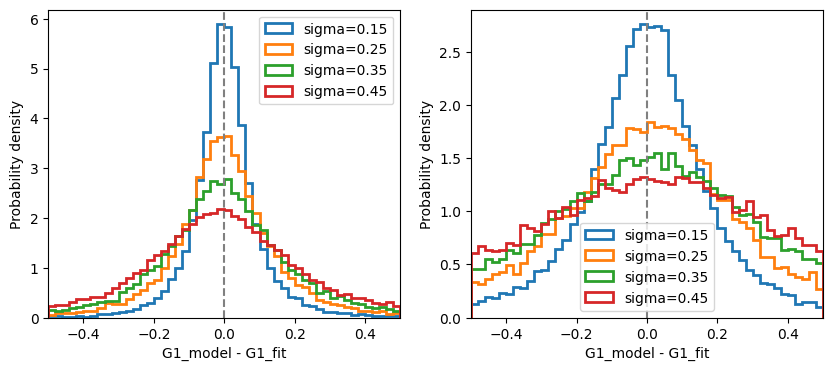

In [104]:
nbins = 50
nrange = (-0.5, 0.5)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
vrange = np.linspace(0.1, 0.5, 5)
for i, _ in enumerate(vrange[:-1]):
    center = (vrange[i] + vrange[i+1]) / 2
    cond = df['sigmas'].between(vrange[i], vrange[i+1])
    # print(vrange[i], vrange[i+1], len(df[cond]))
    axs[0].hist(df.loc[cond, 'G1_model'] - df.loc[cond, 'G1_fit'], 
        bins=nbins, alpha=1.0, histtype='step', lw=2,
        range=nrange, label=f'sigma={center:.2f}', density=True)
    axs[1].hist(df.loc[cond, 'G2_model'] - df.loc[cond, 'G2_fit'], 
        bins=nbins, alpha=1.0, histtype='step', lw=2, density=True,
        range=nrange, label=f'sigma={center:.2f}')

axs[0].set_xlabel('G1_model - G1_fit')
axs[0].set_ylabel('Probability density')
axs[0].set_xlim(-0.5, 0.5)
axs[0].axvline(x=0, color='gray', linestyle='--')
axs[0].legend()

axs[1].set_xlabel('G1_model - G1_fit')
axs[1].set_ylabel('Probability density')
axs[1].set_xlim(-0.5, 0.5)
axs[1].axvline(x=0, color='gray', linestyle='--')
axs[1].legend()
plt.show()

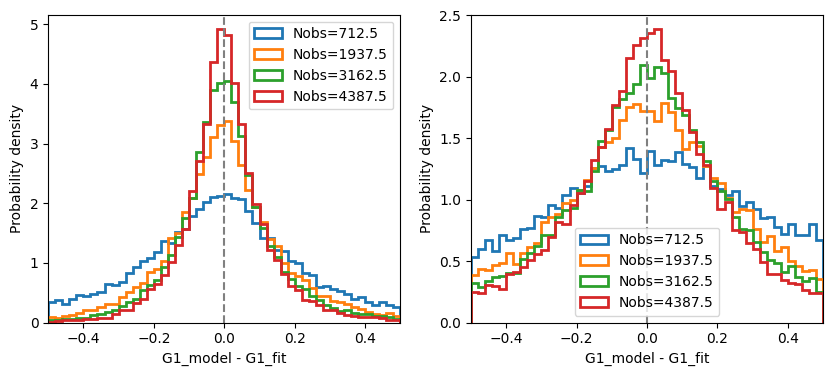

In [105]:
nbins = 50
nrange = (-0.5, 0.5)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
vrange = np.linspace(100, 5000, 5)
for i, _ in enumerate(vrange[:-1]):
    center = (vrange[i] + vrange[i+1]) / 2
    cond = df['nobs'].between(vrange[i], vrange[i+1])
    # print(vrange[i], vrange[i+1], len(df[cond]))
    axs[0].hist(df.loc[cond, 'G1_model'] - df.loc[cond, 'G1_fit'], 
        bins=nbins, alpha=1.0, histtype='step', lw=2, density=True,
        range=nrange, label=f'Nobs={center:.1f}' )
    axs[1].hist(df.loc[cond, 'G2_model'] - df.loc[cond, 'G2_fit'], 
        bins=nbins, alpha=1.0, histtype='step', lw=2, density=True,
        range=nrange, label=f'Nobs={center:.1f}')

axs[0].set_xlabel('G1_model - G1_fit')
axs[0].set_ylabel('Probability density')
axs[0].set_xlim(-0.5, 0.5)
axs[0].axvline(x=0, color='gray', linestyle='--')
axs[0].legend()

axs[1].set_xlabel('G1_model - G1_fit')
axs[1].set_ylabel('Probability density')
axs[1].set_xlim(-0.5, 0.5)
axs[1].axvline(x=0, color='gray', linestyle='--')
axs[1].legend()
plt.show()

In [106]:
nbins = 50
nrange = (-0.5, 0.5)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
vrange = np.linspace(0.01, 5, 5)
for i, _ in enumerate(vrange[:-1]):
    center = (vrange[i] + vrange[i+1]) / 2
    cond = df['p_beg'].between(vrange[i], vrange[i+1])
    # print(vrange[i], vrange[i+1], len(df[cond]))
    axs[0].hist(df.loc[cond, 'G1_model'] - df.loc[cond, 'G1_fit'], 
        bins=nbins, alpha=1.0, histtype='step', lw=2, density=True,
        range=nrange, label=f'p_beg={center:.2f}')
    axs[1].hist(df.loc[cond, 'G2_model'] - df.loc[cond, 'G2_fit'], 
        bins=nbins, alpha=1.0, histtype='step', lw=2, density=True,
        range=nrange, label=f'p_beg={center:.2f}')

axs[0].set_xlabel('G1_model - G1_fit')
axs[0].set_ylabel('Probability density')
axs[0].set_xlim(-0.5, 0.5)
axs[0].axvline(x=0, color='gray', linestyle='--')
axs[0].legend()

axs[1].set_xlabel('G1_model - G1_fit')
axs[1].set_ylabel('Probability density')
axs[1].set_xlim(-0.5, 0.5)
axs[1].axvline(x=0, color='gray', linestyle='--')
axs[1].legend()
plt.show()

20.0 22.5 25069
22.5 25.0 25048
25.0 27.5 24779
27.5 30.0 25104


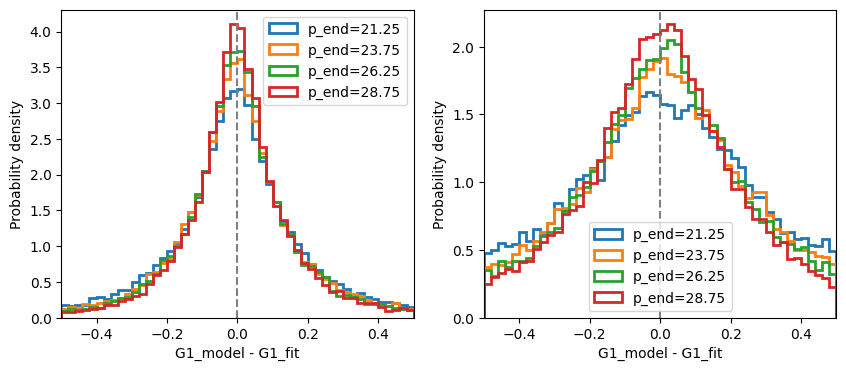

In [107]:
nbins = 50
nrange = (-0.5, 0.5)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
vrange = np.linspace(20, 30, 5)
for i, _ in enumerate(vrange[:-1]):
    center = (vrange[i] + vrange[i+1]) / 2
    cond = df['p_end'].between(vrange[i], vrange[i+1])
    print(vrange[i], vrange[i+1], len(df[cond]))
    axs[0].hist(df.loc[cond, 'G1_model'] - df.loc[cond, 'G1_fit'], 
        bins=nbins, alpha=1.0, histtype='step', lw=2, density=True,
        range=nrange, label=f'p_end={center:.2f}')
    axs[1].hist(df.loc[cond, 'G2_model'] - df.loc[cond, 'G2_fit'], 
        bins=nbins, alpha=1.0, histtype='step', lw=2, density=True,
        range=nrange, label=f'p_end={center:.2f}')

axs[0].set_xlabel('G1_model - G1_fit')
axs[0].set_ylabel('Probability density')
axs[0].set_xlim(-0.5, 0.5)
axs[0].axvline(x=0, color='gray', linestyle='--')
axs[0].legend()

axs[1].set_xlabel('G1_model - G1_fit')
axs[1].set_ylabel('Probability density')
axs[1].set_xlim(-0.5, 0.5)
axs[1].axvline(x=0, color='gray', linestyle='--')
axs[1].legend()
plt.show()

In [109]:
cond = df['nobs'] > 0

dg1 = df.loc[cond, 'G1_model'] - df.loc[cond, 'G1_fit']
dg2 = df.loc[cond, 'G2_model'] - df.loc[cond, 'G2_fit']
# dg1 = df.loc[cond, 'G1_model']
# dg2 = df.loc[cond, 'G2_model']

c = df.loc[cond,'nobs']

# plt.figure()
# cb = plt.scatter(dg1, dg2, 
#             s=10, alpha=1.0, edgecolors='none',
#             c=c, cmap='plasma')
cb = plt.hist2d(dg1, dg2, bins=50, range=[[-1.0, 1.0], [-1.0, 1.0]], 
           cmap='plasma_r',
           norm=mcolors.LogNorm())
plt.colorbar(cb[3], label='Density')
plt.xlabel('G1_model - G1_fit')
plt.ylabel('G2_model - G2_fit')
# plt.xlim(-0.5, 0.5)
# plt.ylim(-1.0, 1.0)
# plt.colorbar(cb, label='nobs')
plt.show()

29899


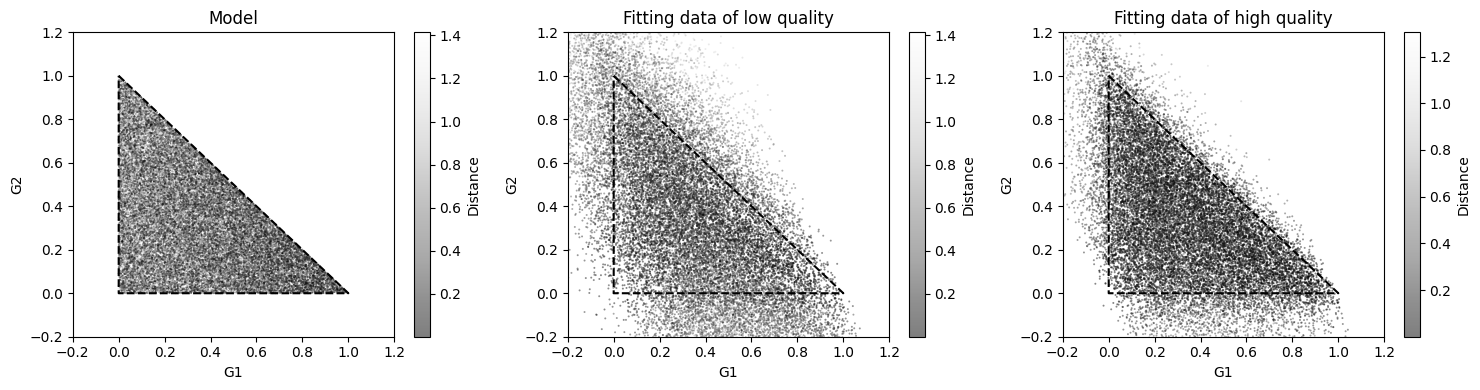

In [155]:
cmap = 'Greys_r'
alpha = 0.5

cond = (df['nobs'].between(100, 3000)) & (df['sigmas'].between(0.3, 0.5))
dg1 = df.loc[cond, 'G1_model'] - df.loc[cond, 'G1_fit']
dg1 = np.where(np.abs(dg1) > 1.0, 1, dg1)
dg2 = df.loc[cond, 'G2_model'] - df.loc[cond, 'G2_fit']
dg2 = np.where(np.abs(dg2) > 1.0, 1, dg2)
color = np.sqrt(np.power(dg1, 2) + np.power(dg2, 2))

plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
plt.subplot(131)
cb = plt.scatter(df.loc[cond, 'G1_model'],
        df.loc[cond, 'G2_model'],
        alpha=alpha, s=2, edgecolors='none',
        c=color, cmap=cmap)
plt.colorbar(cb, label='Distance')
plt.plot([0, 1, 0, 0], [1, 0, 0, 1], color='k', linestyle='--')
plt.xlabel('G1')
plt.ylabel('G2')
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.title('Model')

plt.subplot(132)
print(len(df[cond]))
cb = plt.scatter(df.loc[cond, 'G1_fit'],
        df.loc[cond, 'G2_fit'],
        alpha=alpha, s=2, edgecolors='none',
        c=color, cmap=cmap)
plt.colorbar(cb, label='Distance')
plt.plot([0, 1, 0, 0], [1, 0, 0, 1], color='k', linestyle='--')
plt.xlabel('G1')
plt.ylabel('G2')
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.title('Fitting data of low quality')

cond = (df['nobs'].between(3000, 5000)) & (df['sigmas'].between(0.1, 0.3))
dg1 = df.loc[cond, 'G1_model'] - df.loc[cond, 'G1_fit']
dg1 = np.where(np.abs(dg1) > 1.0, 1, dg1)
dg2 = df.loc[cond, 'G2_model'] - df.loc[cond, 'G2_fit']
dg2 = np.where(np.abs(dg2) > 1.0, 1, dg2)
color = np.sqrt(np.power(dg1, 2) + np.power(dg2, 2))

plt.subplot(133)
cb = plt.scatter(df.loc[cond, 'G1_fit'],
        df.loc[cond, 'G2_fit'],
        alpha=alpha, s=2, edgecolors='none',
        c=color, cmap=cmap)
plt.colorbar(cb, label='Distance')
plt.plot([0, 1, 0, 0], [1, 0, 0, 1], color='k', linestyle='--')
plt.xlabel('G1')
plt.ylabel('G2')
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.title('Fitting data of high quality')
plt.tight_layout()

plt.show()

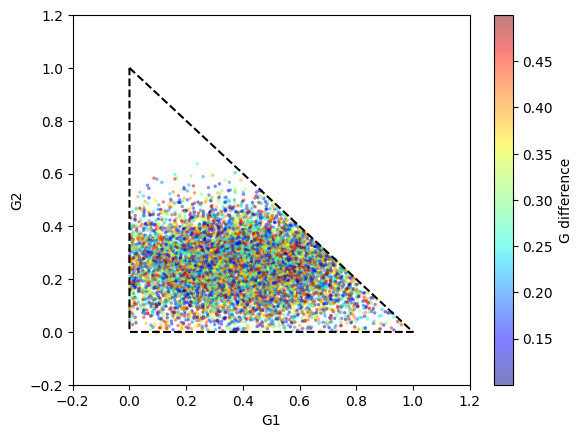

In [124]:
# c = np.sqrt((df['G1_model'] - df['G1_fit'])**2 + (df['G2_model'] - df['G2_fit'])**2)
# c = np.where(c > 1, 1, c)
c = df['sigmas']
cb = plt.scatter(df['G1_model'],
    df['G2_model'],
    alpha=0.5, s=6, edgecolors='none',
    c = c,
    # c=df['nobs'], 
    cmap='jet')

plt.plot([0, 1, 0, 0], [1, 0, 0, 1], color='k', linestyle='--')
plt.xlabel('G1')
plt.ylabel('G2')
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.colorbar(cb, label='G difference')
plt.show()

In [126]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
c = np.sqrt((df['G1_model'] - df['G1_fit'])**2 + (df['G2_model'] - df['G2_fit'])**2)
c = np.where(c > 1, 1, c)
cb = plt.scatter(df['G1_fit'],
    df['G2_fit'],
    alpha=1.0, s=6, edgecolors='none',
    c = c,
    cmap='jet')

plt.plot([0, 1, 0, 0], [1, 0, 0, 1], color='k', linestyle='--')
plt.xlabel('G1')
plt.ylabel('G2')
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.colorbar(cb, label='G difference')

plt.subplot(122)
c = df['sigmas']
cb = plt.scatter(df['G1_fit'],
    df['G2_fit'],
    alpha=1.0, s=6, edgecolors='none',
    c = c,
    cmap='jet')

plt.plot([0, 1, 0, 0], [1, 0, 0, 1], color='k', linestyle='--')
plt.xlabel('G1')
plt.ylabel('G2')
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.colorbar(cb, label='sigma')
plt.tight_layout()
plt.show()

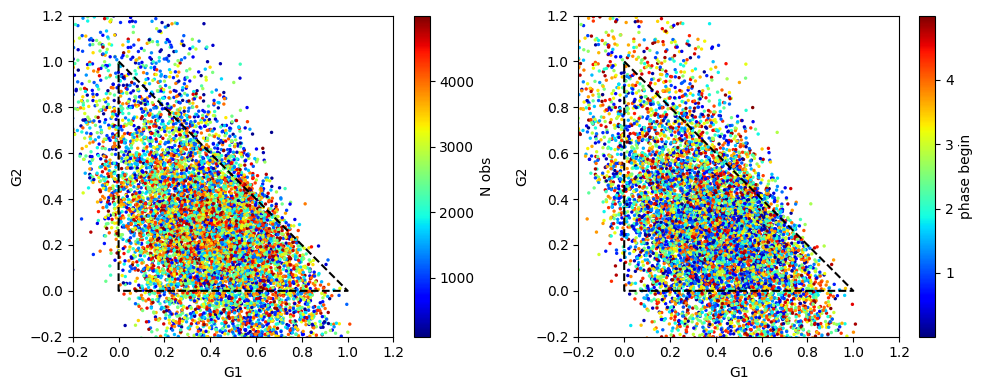

In [127]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
c = df['nobs']
cb = plt.scatter(df['G1_fit'],
    df['G2_fit'],
    alpha=1.0, s=6, edgecolors='none',
    c = c,
    cmap='jet')

plt.plot([0, 1, 0, 0], [1, 0, 0, 1], color='k', linestyle='--')
plt.xlabel('G1')
plt.ylabel('G2')
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.colorbar(cb, label='N obs')

plt.subplot(122)
c = df['p_beg']
cb = plt.scatter(df['G1_fit'],
    df['G2_fit'],
    alpha=1.0, s=6, edgecolors='none',
    c = c,
    cmap='jet')

plt.plot([0, 1, 0, 0], [1, 0, 0, 1], color='k', linestyle='--')
plt.xlabel('G1')
plt.ylabel('G2')
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.colorbar(cb, label='phase begin')
plt.tight_layout()
plt.show()